## Natural Language Processing

In this notebook, we'll try out some NLP techniques on a sentiment analysis task for IMDB movie reviews.

Inspired by: https://www.kaggle.com/jishapjoseph/imdb-sentiment-analysis-v1-tfidf-word2vec

In [22]:
# First, let's import the necessary libraries
import pandas as pd
import seaborn as sns
import numpy as np
import string
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eirik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\eirik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eirik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Import dataset from csv-file using Pandas, and storing as a Dataframe
# The dataset can be found open on Kaggle: https://www.kaggle.com/columbine/imdb-dataset-sentiment-analysis-in-csv-format

df = pd.read_csv('datasets/IMDB_reviews_train.csv')

In [3]:
# Quick overview of the dataset 
# Label 0 means negative, while label 1 means positive
df.head(10)

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
5,A terrible movie as everyone has said. What ma...,0
6,Finally watched this shocking movie last night...,1
7,I caught this film on AZN on cable. It sounded...,0
8,It may be the remake of 1987 Autumn's Tale aft...,1
9,My Super Ex Girlfriend turned out to be a plea...,1


In [4]:
# The first review is negative, here is the text
print(df["text"][0])

I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.


## Data analysis and preprocessing
First we will inspect the dataset and do some preprocessing to it.


In [5]:
# First, we'll copy the original dataset to compare with the preprocessed one later
df_original = df.copy()

In [6]:
#Get word count for dataset
df['word_count'] = df['text'].str.lower().str.len()
df.head(10)

,text,label,word_count
0,I grew up (b. 1965) watching and loving the Th...,0,874
1,"When I put this movie in my DVD player, and sa...",0,1811
2,Why do people who do not know what a particula...,0,983
3,Even though I have great interest in Biblical ...,0,351
4,Im a die hard Dads Army fan and nothing will e...,1,983
5,A terrible movie as everyone has said. What ma...,0,596
6,Finally watched this shocking movie last night...,1,1377
7,I caught this film on AZN on cable. It sounded...,0,1489
8,It may be the remake of 1987 Autumn's Tale aft...,1,1137
9,My Super Ex Girlfriend turned out to be a plea...,1,1468


Text(0.5, 1.0, 'Word Count Distribution')

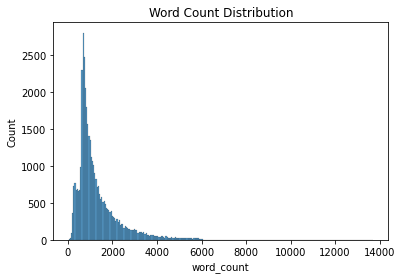

In [7]:
# Show distribution of word counts
sns.histplot(data=df, x="word_count").set_title('Word Count Distribution')

In [8]:
# Method to remove stopwords, remove puncation, make text lowercase and update wordcount

def preprocess_text(data):
    stop = stopwords.words('english')
    punct = string.punctuation
    #Make lower
    data['text'] = data['text'].str.lower()
    #Remove stopwords
    data['text'] = data['text'].apply(lambda x: ' '.join([words for words in x.split() if words not in stop]))
    #Remove punctuations
    data['text'] = data['text'].str.translate(str.maketrans('', '', punct))
    data['word_count'] = data['text'].str.split().str.len()
    return data


In [9]:
df = preprocess_text(df)
df.head()

,text,label,word_count
0,grew b 1965 watching loving thunderbirds mates...,0,87
1,put movie dvd player sat coke chips expectatio...,0,162
2,people know particular time past like feel nee...,0,99
3,even though great interest biblical movies bor...,0,33
4,im die hard dads army fan nothing ever change ...,1,109


In [10]:
print(df['text'][0])

grew b 1965 watching loving thunderbirds mates school watched played thunderbirds school lunch school wanted virgil scott one wanted alan counting 5 became art form took children see movie hoping would get glimpse loved child bitterly disappointing high point snappy theme tune could compare original score thunderbirds thankfully early saturday mornings one television channel still plays reruns series gerry anderson wife created jonatha frakes hand directors chair version completely hopeless waste film utter rubbish cgi remake may acceptable replacing marionettes homo sapiens subsp sapiens huge error judgment


In [11]:
def lemmatize(data):
    lemmatizer = WordNetLemmatizer()
    data['text'] = data['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(w) for w in word_tokenize(x)]))
    return data

In [12]:
df = lemmatize(df)
df.head()

,text,label,word_count
0,grew b 1965 watching loving thunderbird mate s...,0,87
1,put movie dvd player sat coke chip expectation...,0,162
2,people know particular time past like feel nee...,0,99
3,even though great interest biblical movie bore...,0,33
4,im die hard dad army fan nothing ever change t...,1,109


In [13]:
print(df['text'][0])

grew b 1965 watching loving thunderbird mate school watched played thunderbird school lunch school wanted virgil scott one wanted alan counting 5 became art form took child see movie hoping would get glimpse loved child bitterly disappointing high point snappy theme tune could compare original score thunderbird thankfully early saturday morning one television channel still play rerun series gerry anderson wife created jonatha frakes hand director chair version completely hopeless waste film utter rubbish cgi remake may acceptable replacing marionette homo sapiens subsp sapiens huge error judgment


In [14]:
#Remove word_count column, as it may not give us any imporant information for the ML part
df = df[['text','label']]
df

,text,label
0,grew b 1965 watching loving thunderbird mate s...,0
1,put movie dvd player sat coke chip expectation...,0
2,people know particular time past like feel nee...,0
3,even though great interest biblical movie bore...,0
4,im die hard dad army fan nothing ever change t...,1
...,...,...
39995,western union something forgotten classic west...,1
39996,movie incredible piece work explores every noo...,1
39997,wife watched movie plan visit sicily stromboli...,0
39998,first watched flatliners amazed necessary feat...,1


## Creating features
We will make the text understandable for ML models by using n-grams (unigrams and bigrams) and taking the TF-IDF score of these n-grams. We will also try word embeddings to see if that gives better results.

In [15]:
tfidf_converter = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
X = tfidf_converter.fit_transform(df['text']).toarray()
y = df['label']

In [16]:
print(X.shape)
print(X[0])


(40000, 1000)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.15247896 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.17275051 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.      

In [17]:
# Display top-20 tf-idf words
feature_array = tfidf_converter.get_feature_names()
tfidf_sorting = tfidf_converter.idf_

tuples = list(zip(feature_array, tfidf_sorting))
sorted_unigrams = sorted(tuples, key=lambda x: x[1], reverse=True)
print(dict(sorted_unigrams[:100]).keys())

dict_keys(['vampire', 'ghost', 'disney', 'zombie', 'match', 'joe', 'japanese', 'train', 'cat', 'italian', 'alien', 'band', 'german', 'gay', 'lee', 'creature', 'island', 'de', 'cartoon', 'wood', 'teen', 'high school', 'political', 'spirit', 'chase', 'attack', 'color', 'fighting', 'season', 'animal', 'master', 'bill', 'player', 'soldier', 'channel', 'brain', 'fantasy', 'bad guy', 'award', 'married', 'william', 'cute', 'dr', 'dumb', 'footage', 'tension', 'animation', 'remake', 'shoot', 'public', 'baby', 'la', 'new york', 'mistake', 'clever', 'scifi', 'concept', 'memory', 'laughing', 'western', 'creepy', 'odd', 'pretty good', 'throw', 'store', 'us', 'win', 'missed', 'potential', 'tom', 'talented', 'manages', 'telling', 'dance', 'doctor', 'air', 'fear', 'familiar', 'list', 'adventure', 'costume', 'appearance', 'pure', 'company', 'project', 'while', 'ended', 'fails', 'rich', 'wasted', 'feel like', 'fire', 'pace', 'water', 'sexual', 'lover', 'pretty much', 'large', 'ability', 'one thing'])


## Train model

In [18]:
# Split the data into train and test set, based on a 80/20 stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=df['label'])

In [19]:
# We make a function for how to train the models, so we don't have to rewrite the same code more than once

def train_model(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return predictions

In [20]:
# We store an array of models to run through the function from last codeblock.
# They are initialized with default paramters, except for random_state and max_iterations for LR 
random_seed = 42
models = [LogisticRegression(random_state=random_seed, max_iter=500),
          LinearSVC(random_state=random_seed),
          MultinomialNB()]

Report for LogisticRegression:
              precision    recall  f1-score   support

           0      0.859     0.852     0.856      4004
           1      0.853     0.860     0.857      3996

    accuracy                          0.856      8000
   macro avg      0.856     0.856     0.856      8000
weighted avg      0.856     0.856     0.856      8000

Report for LinearSVC:
              precision    recall  f1-score   support

           0      0.858     0.852     0.855      4004
           1      0.852     0.859     0.856      3996

    accuracy                          0.855      8000
   macro avg      0.855     0.855     0.855      8000
weighted avg      0.855     0.855     0.855      8000

Report for MultinomialNB:
              precision    recall  f1-score   support

           0      0.842     0.816     0.829      4004
           1      0.822     0.847     0.834      3996

    accuracy                          0.832      8000
   macro avg      0.832     0.832     0.832      

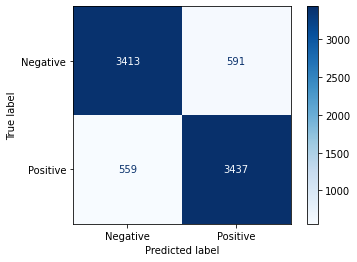

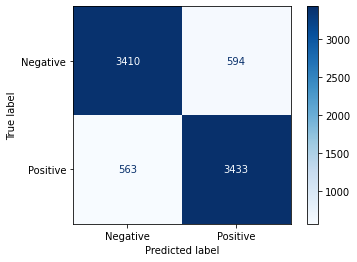

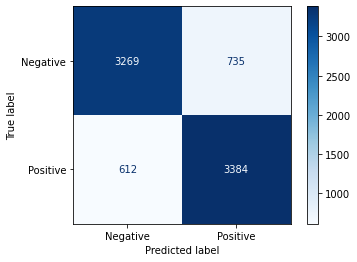

In [21]:
for model in models:
    predictions = train_model(model, X_train, y_train, X_test)
    c_report = classification_report(y_test, predictions, digits=3)
    print(f"Report for {type(model).__name__}:")
    print(c_report)
    
    # Show confusion matrix for each classifier
    conf_mat = confusion_matrix(y_test, predictions)
    cmd = ConfusionMatrixDisplay(conf_mat, display_labels=['Negative','Positive'])
    cmd.plot(cmap='Blues')

In [ ]:
#X_original = tfidf_converter.fit_transform(df_original['text']).toarray()

## Using word2vec embeddings

In [29]:
sentences = pd.Series(df['text']).values

In [30]:
model = Word2Vec(size=50, window=4, min_count=1, workers=4, sg=1)

In [31]:
model.build_vocab(sentences)

In [33]:
model.train(sentences, total_examples=model.corpus_count, epochs=20, report_delay=1)

(118347632, 675989880)

In [38]:
model.wv.most_similar(positive=["movie"])

KeyError: "word 'movie' not in vocabulary"